# Deep Learning &mdash; Assignment 1

First assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_September 2020_

-----

**Names:** Ward Theunisse & Nienke Wessel

**Group:** 25

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite differences method;
4. Use these components to implement and train a simple neural network.

In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization

Consider the following function with two parameters and its derivatives:
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}

In [2]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)
def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2
def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

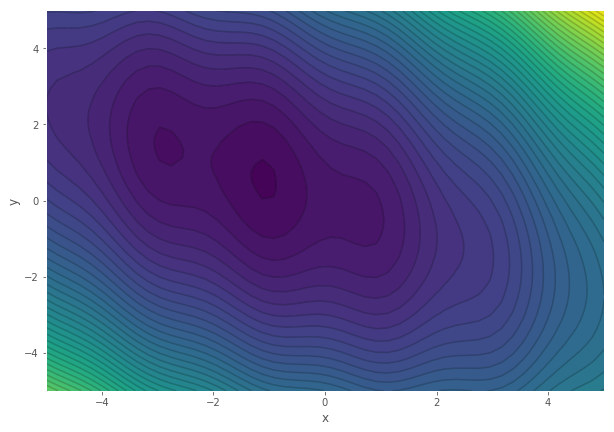

In [3]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**Implement the gradient descent updates for $x$ and $y$ in the function below:**

In [4]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - step_size * dx  # TODO: compute the update
        y = y - step_size * dy # TODO: compute the update

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [5]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')
    
    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

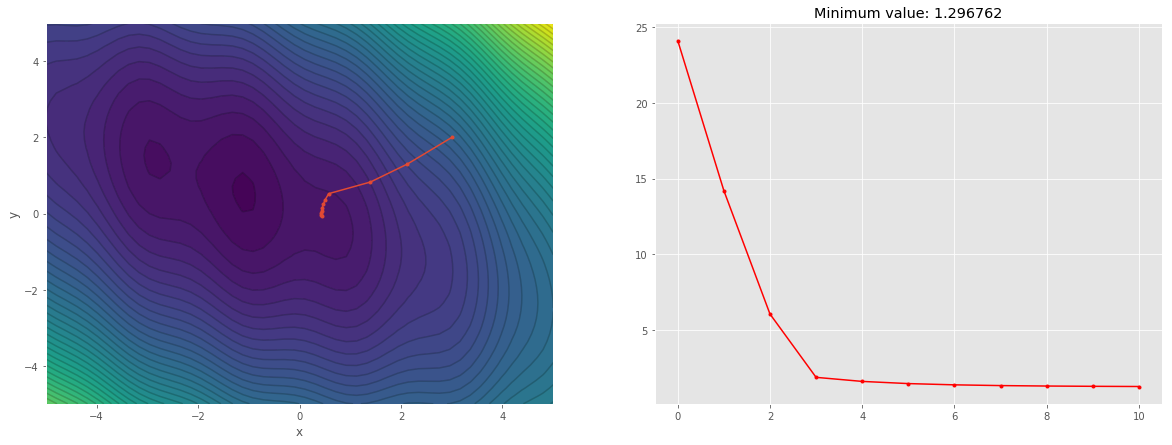

In [6]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**Does it find the minimum of the function? What happens?**

The algorithm finds a local minimum but not the global minimum. 

**Try a few different values for the `step_size` and the number of `steps` to get closes to the optimal solution:**

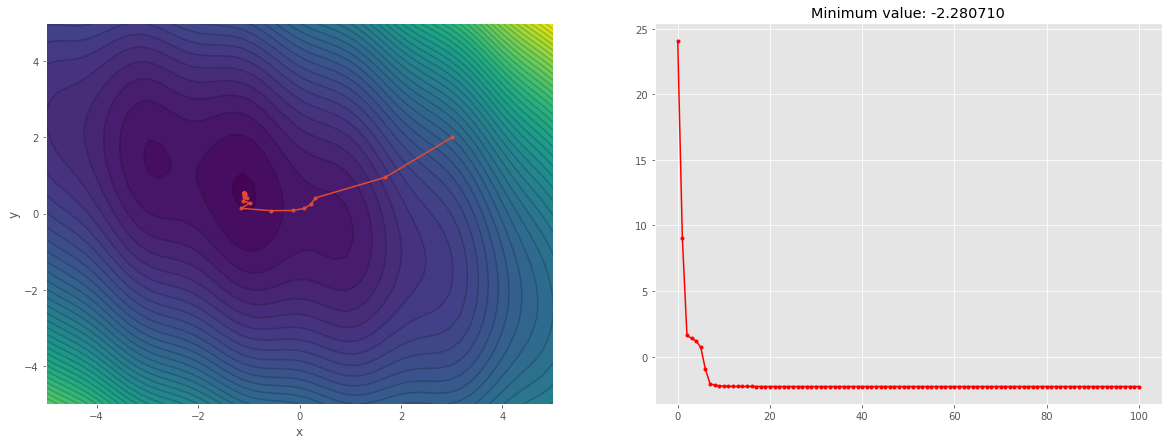

In [7]:
# TODO: tune the parameters to find a better optimum
results = optimize_f(x=3, y=2, step_size=0.15, steps=100)
plot_gradient_descent_results(*results)

**Were you able to find a step size that reached the global optimum? If not, why not?**

Yes, we were. A smaller step size than 0.1 does not seem to help, but a slightly larger one (we used 0.15) 'skips' over the local minimum to the global minimum and then finishes there. (Too large a step size also does not work as it switches between different minima)

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}

**Update your optimization function to use this step size schedule:**

In [8]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - step_size * (decay ** step) * dx # TODO: compute the update including step size decay
        y = y - step_size * (decay ** step) * dy # TODO: compute the update including step size decay

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

**Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:**

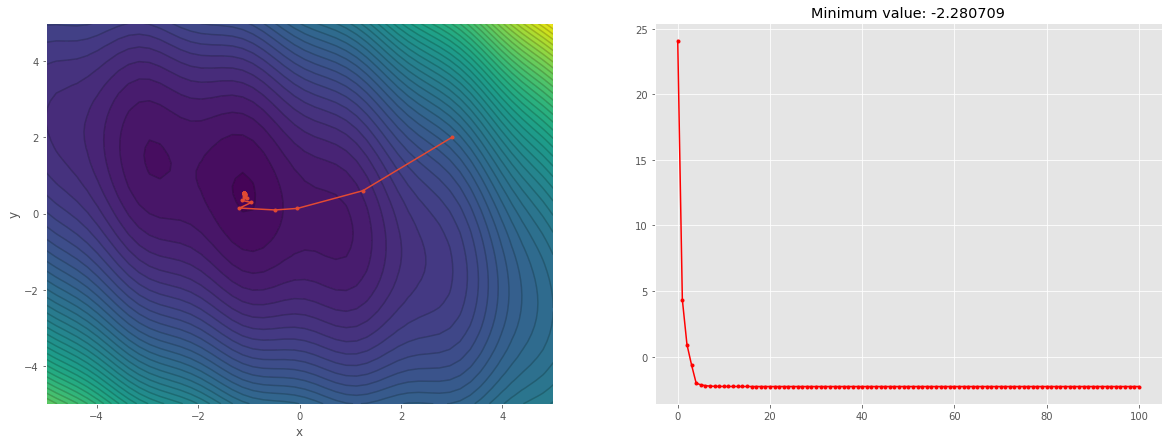

In [9]:
# TODO: tune the parameters to find the local optimum
results = optimize_f(x=3, y=2, step_size=0.2, steps=100, decay=0.95)
plot_gradient_descent_results(*results)

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}

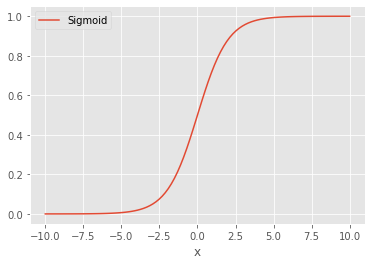

**Give the derivative of the sigmoid function:**

\begin{align}
\frac{\partial \sigma(x)}{\partial x} &= \frac{\partial}{\partial x} (1+e^{-x})^{-1} \\
 &= -1 \cdot (1+e^{-x})^{-2} \cdot (-e^{-x}) \\
 &= (1+e^{-x})^{-2} \cdot e^{-x} \\
 &= (1+e^{-x})^{-1} \cdot (1+e^{-x})^{-1} \cdot e^{-x} \\
 &= \sigma(x) \cdot (1+e^{-x})^{-1} \cdot e^{-x} \\
 &= \sigma(x) \cdot \frac{e^{-x}}{1+e^{-x}} \\
 &= \sigma(x) \cdot \frac{-1 + (1 + e^{-x})}{1+e^{-x}} \\
 &= \sigma(x) \cdot (\frac{-1}{1+e^{-x}} + \frac{1 + e^{-x}}{1+e^{-x}})\\
 &= \sigma(x) \cdot (-\sigma(x) + 1)\\
 &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}


**Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:**

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [ 5.044848 -1.422341 -8.288057 -1.842335  8.040757]
sigmoid(x): [0.993599 0.194295 0.000251 0.136775 0.999678]
sigmoid_grad(x): [0.00636  0.156544 0.000251 0.118068 0.000322]


To check that the gradient implementation is correct, we can compute the numerical derivative using the finite difference method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:**

In [11]:
# start with some random inputs
x = np.random.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic', sigmoid_grad(x))

# TODO: compute the numerical gradient
def num_gradient_sigmoid(x, epsilon):
    return (sigmoid(x + 0.5*epsilon) - sigmoid(x - 0.5*epsilon))/epsilon

print('Finite differences', num_gradient_sigmoid(x, 0.01))

Symbolic [0.139511 0.140679 0.105274 0.19541  0.246271]
Finite differences [0.139511 0.140679 0.105274 0.19541  0.246271]


**Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?**

They are not exactly the same, as the finite differences is only an approximation. In order for it to be exactly the same, one would have to make epsilon infinitely small, but that is not possible on a computer. With the current epsilon (0.01) they look the same for the six digits that are shown after rounding. 

**If there is a visible difference between the two gradients, please try to make this a small as possible before you continue.**

## Rectified linear units (ReLU)

The rectified linear unit is defined as:
\begin{align}
  f(x) = \max(0, x)
\end{align}

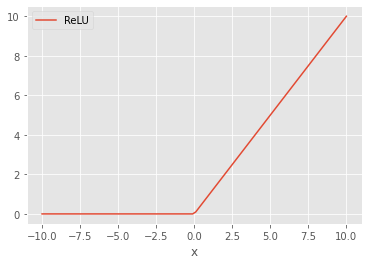

**Give the derivative of the ReLU function:**

\begin{align}
  \frac{\partial f(x)}{\partial x} &= \frac{\partial}{\partial x}max(0,x)\\
        &= \frac{\partial}{\partial x} \left\{\begin{array}{lr}
        0, & \text{for } x < 0\\
        x, & \text{for } 0 \le x
        \end{array}\right.\\
        &= \left\{\begin{array}{lr}
        \frac{\partial}{\partial x} 0, & \text{for } x < 0\\
        \frac{\partial}{\partial x} x, & \text{for } 0 \le x
        \end{array}\right.\\
        &= \left\{\begin{array}{lr}
        0, & \text{for } x < 0\\
        1, & \text{for } 0 \le x
        \end{array}\right.
\end{align}

Strictly seen, ReLU is not differentiable at 0, but that is undesirable in a setting where we do need a result, so we've chosen to define it as part of the case where the max returns x.

**Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite differences method to check that the gradient is correct:**

In [12]:
def relu(x):
    # DONE: implement the relu function
    return np.maximum(0,x)

def relu_grad(x):
    # DONE: implement the gradient of the relu function
    return 0 if x < 0 else 1
relu_grad = np.vectorize(relu_grad)

# try with a random input
x = np.random.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))
print()

# DONE: compute and compare the symbolic and numerical gradients
print('Symbolic:', relu_grad(x))

def num_gradient_relu(x, epsilon):
    return (relu(x + 0.5*epsilon) - relu(x - 0.5*epsilon))/epsilon

print('Finite differences', num_gradient_relu(x, 0.01))

x: [5.636688 7.488439 4.418439 6.663227 3.226479]
relu(x): [5.636688 7.488439 4.418439 6.663227 3.226479]
relu_grad(x): [1 1 1 1 1]

Symbolic: [1 1 1 1 1]
Finite differences [1. 1. 1. 1. 1.]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

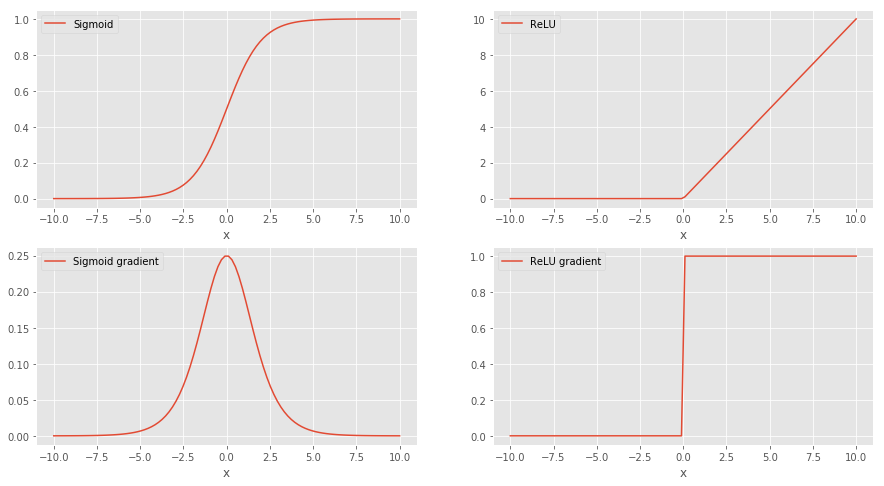

In [13]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in (0, 1)$? Why?**

Sigmoid. In the domain of probabilities, we're not just interested in the outer edges of the domain: we are also really interested in the probabilities that fall inbetween. W.r.t. the activation functions of the hidden layers, the sigmoid function also captures more granularity (more values of the state space are utilised).

**Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function?**

ReLU is really easy / fast to compute, and the gradient is consistently large, even for very small values of x, so you don't suffer from a vanishing gradient (for positive values).
However, it's gradient being zero for values below zero would tend it to not learn anymore and become "stuck", which is undesirable.

Sigmoid has a soft transition, leading to a larger granularit in outputs.
However, for some values, the gradient approaches zero, which really slows learning.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in (0, 1)$:

\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}

To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**Derive the gradient for the BCE loss:**

\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= \frac{\partial}{\partial \hat{y}} -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
    &= -(\frac{\partial}{\partial \hat{y}} (y \log{\hat{y}}) + \frac{\partial}{\partial \hat{y}}((1-y) \log(1-\hat{y}))) \\
    &= -( y * \frac{\partial}{\partial \hat{y}}\log{\hat{y}} + (1-y) * \frac{\partial}{\partial \hat{y}}\log(1-\hat{y})) \\
    &= -( y * \frac{1}{\hat{y}} + (1-y) * \frac{\partial}{\partial \hat{y}}\log(1-\hat{y})) \\
    &= -(\frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}}) \\
    &= -(\frac{y (1-\hat{y})}{\hat{y} (1-\hat{y})} - \frac{\hat{y}(1-y)}{\hat{y} (1-\hat{y})}) \\
    &= -(\frac{y-y\hat{y}}{\hat{y} (1-\hat{y})} + \frac{-\hat{y}+\hat{y}y}{\hat{y} (1-\hat{y})}) = -(\frac{y-\hat{y}}{\hat{y} (1-\hat{y})}) = \frac{\hat{y}-y}{\hat{y} (1-\hat{y})} \\
\end{align}

**Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite differences method to check that the gradient is correct:**

In [14]:
def bce_loss(y, y_hat):
    # DONE: implement the BCE loss
    return -(y*np.log(y_hat) + (1-y) * np.log(1-y_hat))

def bce_loss_grad(y, y_hat):
    # DONE: implement the gradient of the BCE loss
    return (y_hat - y) / (y_hat * (1 - y_hat))

# try with some random inputs
y = np.random.randint(2, size=5)
y_hat = np.random.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print()

# TODO: compute and compare the symbolic and numerical gradients
print('Symbolic:', bce_loss_grad(y, y_hat))

def num_gradient_bce(y, y_hat, epsilon):
    return (bce_loss(y, y_hat + 0.5*epsilon) - bce_loss(y, y_hat - 0.5*epsilon))/epsilon

print('Finite differences', num_gradient_bce(y, y_hat, 0.01))


y: [1 1 1 0 1]
y_hat: [0.830152 0.630334 0.153277 0.789648 0.282017]
bceloss(y, y_hat): [0.186147 0.461506 1.875507 1.558971 1.265789]

Symbolic: [-1.204599 -1.586461 -6.524125  4.753925 -3.54589 ]
Finite differences [-1.204614 -1.586495 -6.52644   4.754821 -3.546262]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:**


#TODO double check this

\begin{align}
  \nabla_\mathbf{x} \mathbf{y} &= \nabla_\mathbf{x} (\mathbf{x} \mathbf{W} + \mathbf{b}) \\
  &= \nabla_\mathbf{x} (\mathbf{x} \mathbf{W}) + \nabla_\mathbf{x}\mathbf{b} \\
  &= W^T + 0 = W^T
\end{align}

\begin{align}
  \nabla_\mathbf{W} \mathbf{y} &= \nabla_\mathbf{W} (\mathbf{x} \mathbf{W} + \mathbf{b}) \\
  &= \nabla_\mathbf{W} (\mathbf{x} \mathbf{W}) + \nabla_\mathbf{W} \mathbf{b} \\
  &= \mathbf{x}^T + 0 = \mathbf{x}^T
\end{align}

\begin{align}
  \nabla_\mathbf{b} \mathbf{y} &= \nabla_\mathbf{b} (\mathbf{x} \mathbf{W} + \mathbf{b}) \\
  &= \nabla_\mathbf{b} (\mathbf{x} \mathbf{W}) + \nabla_\mathbf{b} \mathbf{b} \\
  &= 0 + I = I\\
\end{align}

**Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:**

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial \mathbf{x}}\\
  &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}}\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \nabla_\mathbf{y} \mathcal{L} \nabla_\mathbf{x} \mathbf{y} = \nabla_\mathbf{y} \mathcal{L} \mathbf{W}^T
\end{align}

\begin{align}
  \nabla_\mathbf{W} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial \mathbf{W}}\\
  &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}}\frac{\partial \mathbf{y}}{\partial \mathbf{W}} = \frac{\partial \mathbf{y}}{\partial \mathbf{W}}\frac{\partial \mathcal{L}}{\partial \mathbf{y}} = \nabla_\mathbf{W} \mathbf{y} \nabla_\mathbf{y} \mathcal{L}  = \mathbf{x}^T\nabla_\mathbf{y} \mathcal{L} 
\end{align}

\begin{align}
  \nabla_\mathbf{b} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial \mathbf{b}}\\
  &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}}\frac{\partial \mathbf{y}}{\partial \mathbf{b}} = \nabla_\mathbf{y} \mathcal{L} \nabla_\mathbf{b} \mathbf{y} = \nabla_\mathbf{y} \mathcal{L} I = \nabla_\mathbf{y} \mathcal{L}
\end{align}


## 1.3 Implement a one-layer model

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

\begin{align}
h = \mathbf{x}^T \mathbf{w} + b \\
\hat{y} = \sigma(h) \\
\end{align}

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$:

\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial \mathbf{x}}\\
  &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}\\
  &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial \mathbf{x}}\\
\end{align}

**Complete the implementation below:**

In [15]:
# initialize parameters
w = np.random.uniform(size=5)
b = np.random.rand()

# implement the model
def fn(x, y):
    # DONE: forward: compute h, y_hat, loss
    h = x.dot(w) + b
    y_hat = sigmoid(h)
    loss = bce_loss(y, y_hat)
    
    # DONE: backward: compute grad_y_hat, grad_h, grad_x
    grad_y_hat = bce_loss_grad(y, y_hat) # Gradient of loss func w.r.t y_hat
    grad_h = grad_y_hat * sigmoid_grad(h) # Gradient of loss func w.r.t h
    grad_x = grad_h * w # Gradient of loss func w.r.t. x
    
    return loss, grad_x

# test with a random input
x = np.ones((5,))#np.random.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

Loss 0.061126062909673845
Gradient [-0.051182 -0.017641 -0.051237 -0.01718  -0.000469]


**Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [16]:
# start with some random inputs
x = np.random.uniform(size=5)
y = 1

# set epsilon to a small value
eps = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps / 2
    x_b[i] -= eps / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a - loss_b) / eps

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)
    
print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

Symbolic gradient
[-0.205776 -0.070926 -0.205999 -0.069071 -0.001886]
Numerical gradient
[-0.205776 -0.070926 -0.205999 -0.069071 -0.001886]


## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions

We will now construct a simple neural network. We need to implement the folowing objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the weights, based on the gradient computed by `backward`.

**Implement a class `Linear` that computes `y = x*W + b`:**

In [17]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        # DONE: compute the forward pass
        y = x.dot(self.W) + self.b
        #print("input of shape",x.shape)
        #print("weights of shape", self.W.shape)
        #print("output of shape",y.shape)
        return y

    def backward(self, x, dy):
        # DONE: compute the backward pass,
        # given dy, compute the gradients for x, W and b
        dx = dy.dot(self.W.T)
        self.dW = x.T.dot(dy)
        self.db = np.sum(dy,axis=0)#np.ones((1,x.shape[0])).dot(dy)
        #print("dy",dy)
        #print(self.db)
        #print(dy.shape)
        #print(np.ones((self.b.shape[0],self.b.shape[0])).shape)
        #print(self.db.shape)
        #print("dx",dx.shape)
        return dx
    
    def step(self, step):
        #raise NotImplementedError  # DONE?
        # TODO: apply a gradient descent update step
        self.W = self.W - step*self.dW  # DONE?
        self.b = self.b - step*self.db # DONE?
        
    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each
# dimension, so you'll get an error if you mix them up.
x = np.random.uniform(size=(3, 5))

layer = Linear(5, 7)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[-0.089755 -0.206227 -0.413744  0.405997 -0.024196  0.341687  0.419334]
 [-0.137369 -0.164599 -0.416627  0.246486  0.222668  0.199937  0.497592]
 [-0.35406  -0.237123 -0.134597  0.461111  0.103766  0.359734  0.123361]]
dx: [[ 0.066349  0.307645  0.32633   0.11034  -0.092874]
 [ 0.066349  0.307645  0.32633   0.11034  -0.092874]
 [ 0.066349  0.307645  0.32633   0.11034  -0.092874]]


**Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:**

In [18]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        # DONE: compute the forward pass
        return sigmoid(x)

    def backward(self, x, dy):
        # DONE: compute the backward pass,
        # return the gradient for x given dy
        return dy * sigmoid_grad(x)
    
    def step(self, step_size):
        #raise NotImplementedError  # TODO
        return
    
    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
x = np.random.uniform(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.670335 0.722953 0.587699 0.528931 0.714446]
 [0.70388  0.561949 0.69742  0.673355 0.503916]
 [0.660563 0.52696  0.574788 0.658705 0.532889]]
dx: [[0.220986 0.200292 0.242309 0.249163 0.204013]
 [0.208433 0.246162 0.211025 0.219948 0.249985]
 [0.22422  0.249273 0.244407 0.224813 0.248918]]


**Implement a class `ReLU` that computes `y = max(0, x)`:**

In [19]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        # DONE: compute the forward pass
        return relu(x)

    def backward(self, x, dy):
        # DONE: compute the backward pass,
        # return the gradient for x given dy
        return dy * relu_grad(x)
    
    def step(self, step_size):
        #raise NotImplementedError  # TODO
        return
    
    def __str__(self):
        return 'ReLU'


# try the new class with some random values
x = np.random.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

y: [[0.       0.       0.       6.760611 0.      ]
 [4.850774 0.       5.604991 0.       0.      ]
 [8.274109 6.895369 0.       9.71315  3.297718]]
dx: [[0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]]


### Verify the gradients (using provided code)

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**Run the code and check that the error is not too large.**

In [20]:
## Verify gradient computations for Linear
# test for dx
layer = Linear(5, 7)
def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=3 * 5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for dW
x = np.random.uniform(size=(3, 5))
layer = Linear(5, 7)
def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5 * 7))
print("err on dW:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

# test for db
x = np.random.uniform(size=(3, 5,))
layer = Linear(5, 7)
def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=7))
print("err on db:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 8.163466191454083e-07
err on dW: OK 3.0827970880318133e-06
err on db: OK 0.0


In [21]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(-10, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 2.851954923176839e-08


In [22]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()
def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))
def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))

err = scipy.optimize.check_grad(test_fn, test_fn_grad,
                                np.random.uniform(1, 10, size=5))
print("err on dx:", "OK" if np.abs(err) < 1e-5 else "ERROR", err)

err on dx: OK 0.0


## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**Read the code below:**

In [23]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

digits_x.shape: (1797, 64)
digits_y.shape: (1797,)
min, max values: -0.8117561971974786 1.847470154168513
labels: [0. 1.]


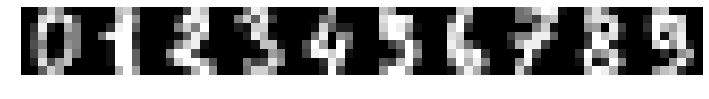

In [24]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

We divide the dataset in a train and a test set.

In [25]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
idxs = np.random.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test':  digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test':  digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

Training samples: 898
Test samples: 899


We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**Read through the code below.**

In [26]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**Train the network and inspect the results. Tune the hyperparameters to get a good result.**

Epoch   0: loss[train]= 0.4225  accuracy[train]= 0.8213  loss[test]= 0.3472  accuracy[test]= 0.8584
Epoch   1: loss[train]= 0.2390  accuracy[train]= 0.9124  loss[test]= 0.3097  accuracy[test]= 0.8719
Epoch   2: loss[train]= 0.1773  accuracy[train]= 0.9393  loss[test]= 0.2393  accuracy[test]= 0.9101
Epoch   3: loss[train]= 0.1374  accuracy[train]= 0.9607  loss[test]= 0.1878  accuracy[test]= 0.9292
Epoch   4: loss[train]= 0.1103  accuracy[train]= 0.9663  loss[test]= 0.1622  accuracy[test]= 0.9393
Epoch   5: loss[train]= 0.0908  accuracy[train]= 0.9730  loss[test]= 0.1405  accuracy[test]= 0.9449
Epoch   6: loss[train]= 0.0765  accuracy[train]= 0.9787  loss[test]= 0.1318  accuracy[test]= 0.9472
Epoch   7: loss[train]= 0.0649  accuracy[train]= 0.9798  loss[test]= 0.1207  accuracy[test]= 0.9551
Epoch   8: loss[train]= 0.0558  accuracy[train]= 0.9843  loss[test]= 0.1163  accuracy[test]= 0.9573
Epoch   9: loss[train]= 0.0476  accuracy[train]= 0.9899  loss[test]= 0.1143  accuracy[test]= 0.9573


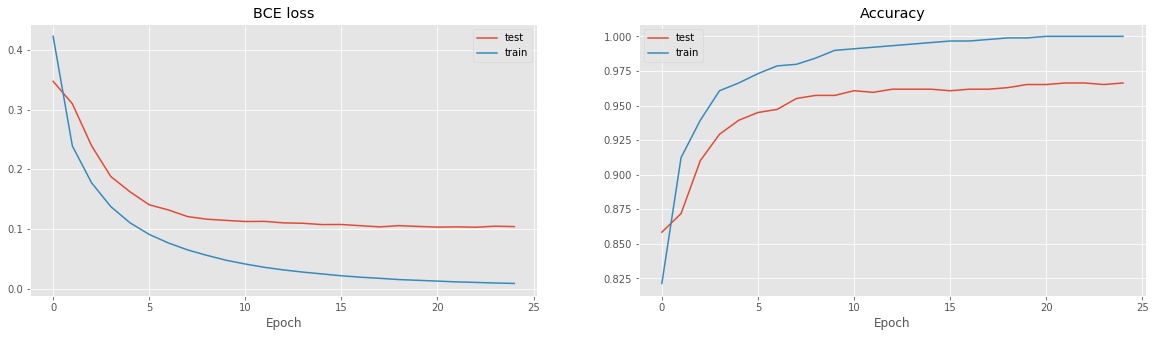

In [27]:
# construct network
net = Net([
        Linear(64, 32),
        ReLU(),
        Linear(32, 1),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 10)


**Which of the hyperparameters (number of epochs, learning rate, minibatch size) was most important? How did they influence your results?**

Changing the minibatch size seems to make little difference. Though, if the learning rate is failry high, larger minibatches seem to lead to more fluctuation in accuracy over time. The learning rate makes quite the difference and if we define it too high, it runs into problems as it tries to divide by zero. The number of epochs only makes a difference in as far as it gets enough epochs to reach 100% accuracy on the training set.

**Repeat the experiment with a the same network, but remove the ReLU activation in the middle: `[Linear, Linear, Sigmoid]`.**

Epoch   0: loss[train]= 0.4218  accuracy[train]= 0.8056  loss[test]= 0.4088  accuracy[test]= 0.8213
Epoch   1: loss[train]= 0.3050  accuracy[train]= 0.8831  loss[test]= 0.4508  accuracy[test]= 0.8135
Epoch   2: loss[train]= 0.2835  accuracy[train]= 0.8910  loss[test]= 0.4499  accuracy[test]= 0.8124
Epoch   3: loss[train]= 0.2722  accuracy[train]= 0.8944  loss[test]= 0.4348  accuracy[test]= 0.8225
Epoch   4: loss[train]= 0.2648  accuracy[train]= 0.8944  loss[test]= 0.4188  accuracy[test]= 0.8292
Epoch   5: loss[train]= 0.2595  accuracy[train]= 0.8978  loss[test]= 0.4052  accuracy[test]= 0.8337
Epoch   6: loss[train]= 0.2555  accuracy[train]= 0.9000  loss[test]= 0.3943  accuracy[test]= 0.8416
Epoch   7: loss[train]= 0.2522  accuracy[train]= 0.9011  loss[test]= 0.3858  accuracy[test]= 0.8472
Epoch   8: loss[train]= 0.2496  accuracy[train]= 0.9034  loss[test]= 0.3792  accuracy[test]= 0.8528
Epoch   9: loss[train]= 0.2474  accuracy[train]= 0.9045  loss[test]= 0.3740  accuracy[test]= 0.8573


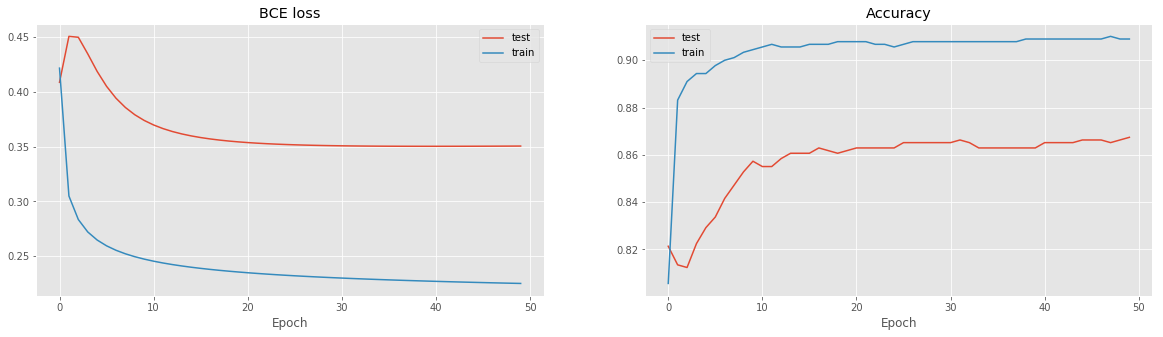

In [28]:
# TODO: Your code here.
# construct network
net2 = Net([
        Linear(64, 32),
        Linear(32, 1),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net2, x, y,
    epochs = 50,
    learning_rate = 0.01,
    mb_size = 10)

**How does the performance of this network compare with the previous network. Can you explain this result? How does removing the ReLU affect the model?**

After the model minimizes the loss on the test set, it doesn't slowly improve anymore like the other model did, but just stays the same, while the previous network continued to improve performance on the test set after the "bend" in the graph.

Similarly, the accuracy on the test set stays stable over the entire training, suggesting almost no actual improvement is taking place.

Even for a large amount of epochs, the training accuracy is quite slow to, and never quite reaches 1.00, meaning that it is almost not even powerful enough to overfit well.

Removing the ReLU means that two linear layers follow one another, which is equivalent to a single linear layer in terms of the decision boundaries it can represent.

In a sense this network just has a lot less descriptive power / is less able to model distributions that aren't very simple.

**Create a network with one linear layer followed by a sigmoid activation:**

`net = Net([Linear(...), Sigmoid()]`

**Train this network. Compare the results with the `[Linear, ReLU, Linear, Sigmoid]` and `[Linear, Linear, Sigmoid]` networks you trained before, and explain the results.**

Epoch   0: loss[train]= 0.4821  accuracy[train]= 0.7719  loss[test]= 0.4286  accuracy[test]= 0.8135
Epoch   1: loss[train]= 0.3209  accuracy[train]= 0.8730  loss[test]= 0.3943  accuracy[test]= 0.8348
Epoch   2: loss[train]= 0.2907  accuracy[train]= 0.8876  loss[test]= 0.3769  accuracy[test]= 0.8494
Epoch   3: loss[train]= 0.2754  accuracy[train]= 0.8899  loss[test]= 0.3661  accuracy[test]= 0.8573
Epoch   4: loss[train]= 0.2658  accuracy[train]= 0.8966  loss[test]= 0.3589  accuracy[test]= 0.8607
Epoch   5: loss[train]= 0.2591  accuracy[train]= 0.8955  loss[test]= 0.3537  accuracy[test]= 0.8573
Epoch   6: loss[train]= 0.2542  accuracy[train]= 0.8966  loss[test]= 0.3501  accuracy[test]= 0.8640
Epoch   7: loss[train]= 0.2504  accuracy[train]= 0.9000  loss[test]= 0.3474  accuracy[test]= 0.8640
Epoch   8: loss[train]= 0.2473  accuracy[train]= 0.9011  loss[test]= 0.3454  accuracy[test]= 0.8663
Epoch   9: loss[train]= 0.2449  accuracy[train]= 0.9034  loss[test]= 0.3441  accuracy[test]= 0.8685


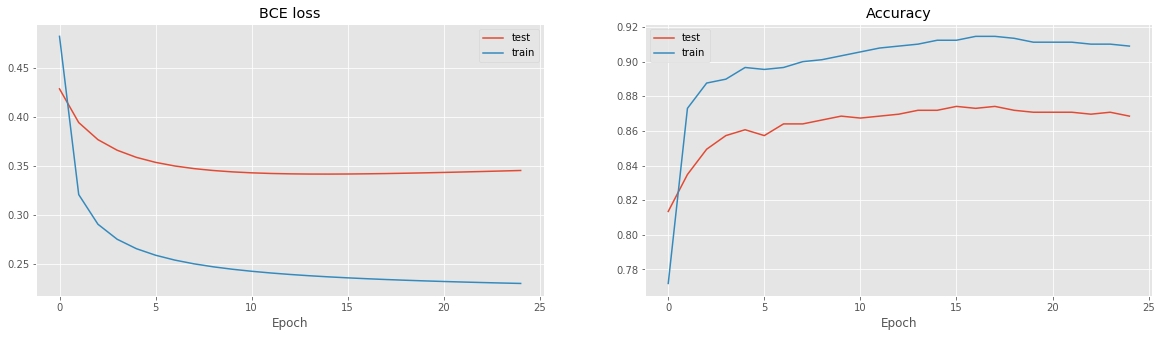

In [29]:
# TODO: Your code here.
# construct network
net3 = Net([
        Linear(64, 1),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net3, x, y,
    epochs = 25,
    learning_rate = 0.01,
    mb_size = 10)

**Discuss your results.**

It does not learn as well as the complete network, but on a similar level as the previous one. This makes sense, as two linear layers behind each other can just be combined into one single linear layer (since linear + linear remains linear). So the extra linear layer does not add much. 

**Try a deeper network (e.g., four linear layers) to see if this can improve the results further.**

Epoch   0: loss[train]= 0.6922  accuracy[train]= 0.5281  loss[test]= 0.6948  accuracy[test]= 0.4663
Epoch   1: loss[train]= 0.6903  accuracy[train]= 0.5371  loss[test]= 0.6962  accuracy[test]= 0.4663
Epoch   2: loss[train]= 0.6894  accuracy[train]= 0.5371  loss[test]= 0.6971  accuracy[test]= 0.4663
Epoch   3: loss[train]= 0.6887  accuracy[train]= 0.5371  loss[test]= 0.6975  accuracy[test]= 0.4663
Epoch   4: loss[train]= 0.6879  accuracy[train]= 0.5371  loss[test]= 0.6975  accuracy[test]= 0.4663
Epoch   5: loss[train]= 0.6870  accuracy[train]= 0.5371  loss[test]= 0.6971  accuracy[test]= 0.4663
Epoch   6: loss[train]= 0.6858  accuracy[train]= 0.5371  loss[test]= 0.6962  accuracy[test]= 0.4663
Epoch   7: loss[train]= 0.6842  accuracy[train]= 0.5371  loss[test]= 0.6948  accuracy[test]= 0.4663
Epoch   8: loss[train]= 0.6820  accuracy[train]= 0.5371  loss[test]= 0.6926  accuracy[test]= 0.4663
Epoch   9: loss[train]= 0.6787  accuracy[train]= 0.5371  loss[test]= 0.6890  accuracy[test]= 0.4663


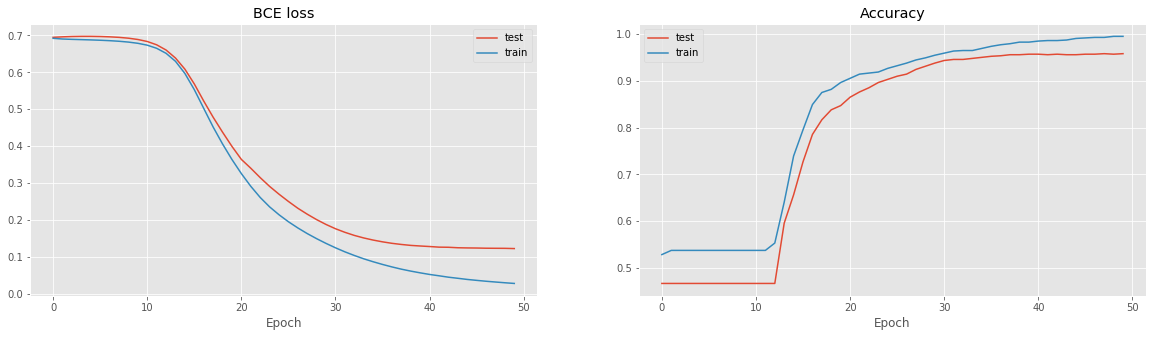

In [30]:
# construct network
net = Net([
        Linear(64, 48),
        ReLU(),
        Linear(48, 32),
        ReLU(),
        Linear(32, 21),
        ReLU(),
        Linear(21, 1),
        Sigmoid()])

# TODO: tune the hyperparameters
fit(net, x, y,
    epochs = 50,
    learning_rate = 0.001,
    mb_size = 10)

**Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.**

We almost got a perfect classification, but not quite yet on the test set. We see that at the start the network learns quite a lot, because there is still quite a lot to learn. Later on, there is not much to learn left, and the network learns way more slowly. It is normal that the performance on the test set remains slightly below the training set, as we do not use the test set in the learning procedure. Fortunately, they do stay quite close together, meaning that the network has learned to generalise relatively well.

## 1.7 Final questions

You now have some experience training neural networks. Time for a few final questions.

**What is the influence of the learning rate? What happens if the learning rate is too low or too high?**

The learning rate, as the name suggests, determines how fast the network learns. If it is too low, the network will only converge very slowly after many iterations, which can become quite costly. If it is too high, the learning becomes erratic and might even diverge, which means the results can also take longer or no result will be reached at all. 

**What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.**

Minibatch size is a tradeoff between following an accurate gradient for a somewhat higher computation cost versus an approximate gradient that is faster to compute, multiple times per epoch.
Smaller batches allow you to update weights more often, but this update is less accurate.

**In the linear layer, we initialized the weights $w$ with random weights, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?**

If we initialize the weights with zero, multiplying with x will again result in an all zero matrix, losing all information of the previous layers. This will make it hard for the gradient to find a direction / diverge in function from other neurons on that layer. Futhermore, the dx that is passed on to the previous layer is based on the weights, so until the weights on this layer slowly leave zero, the gradient propagated back will be tiny.

For b, this is not a problem, because it is only the bias, and if x and W are not zero, then the network will still learn things and update b. The propagated gradient is not based on b.

## The end

Well done! Please double check the instructions at the top before you submit your results.